# Spatial Models

Overview of today's topics:

  - quick refresher
  - spatial fixed effects
  - spatial regimes
  - spatial lag
  - spatial error
  - geographically-weighted regression
  
## 1. Quick refresher

### 1.1. Theory and models

**Spatial models** are models that include geographic information to account for spatial relationships and processes. They can take on many different forms:

  - Spatially-explicit regression models (with [PySAL](https://pysal.org))
  - Agent-based models and/or cellular automata (with [Mesa](https://mesa.readthedocs.io/))
  - Bayesian spatial models using Markov chain Monte Carlo methods (with [PyMC3](https://docs.pymc.io/))

We will focus on spatially-explicit regression models here. Spatially-explicit regression models are a type of **statistical model**: sets of assumptions plus mathematical relationships between variables, producing a formal representation of some theory. We are essentially trying to explain the process underlying the generation of our observed data. **Spatial inference** introduces explicit spatial relationships into the statistical modeling framework, as both theory-driven (e.g., spatial spillovers) and data-driven (e.g., MAUP) issues could otherwise violate modeling assumptions.

### 1.2. Statistical inference refresher

**Statistical inference** is the process of using a sample to *infer* the characteristics of an underlying population (from which this sample was drawn) through estimation and hypothesis testing. What is the probability distribution (the probabilities of occurrence of different possible outcome values of our response variable)? Contrast this with descriptive statistics, which focus simply on describing the characteristics of the sample itself.

Common goals of inferential statistics include:

  - parameter estimation and confidence intervals
  - hypothesis rejection
  - prediction and explanation
  - model selection

Schools of statistical inference:

  - frequentist
    - frequentists think of probability as proportion of time some outcome occurs (relative frequency)
    - given lots of repeated trials, how likely is the observed outcome?
    - concepts: statistical hypothesis testing, *p*-values, confidence intervals
  - bayesian
    - bayesians think of probability as amount of certainty observer has about an outcome occurring (subjective probability)
    - probability as a measure of how much info the observer has about the real world, updated as info changes
    - concepts: prior probability, likelihood, bayes' rule, posterior probability
    
### 1.3. Regression refresher

This course presumes you're already comfortable with multiple regression and OLS, as a prerequisite.

Regression assumptions:

  - an additive, linear relationship between response and predictors
  - uncorrelated predictors
  - uncorrelated, homoskedastic, normally-distributed errors
  
Regression topics:

  - specification: choosing variables to include and the functional form
  - transformation: pre-processing to improve linear fit (log, power, etc) and feature scaling
  - estimation: using an algorithm (such as OLS, WLS, MLE, etc) to estimate (aka, fit or train) your model's parameters
  - validation and diagnostics: model's goodness of fit ($R^2$), parameters' statistical significance ($t$-test and $p$-values), check errors and assumptions (diagnostic tests, residual plot, Q-Q plot, etc), outlier influence (leverage), robustness checks (alternative specifications)
  - resampling: cross-validation (out-of-sample prediction with train/test subsets) and bootstrapping (random subsampling to generate estimates' distribution)
  - model selection and regularization: bias-variance tradeoff (over/under-fitting), lasso (L1 regularization), ridge (L2 regularization), hyperparameters
  
## 2. Setup and data prep

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pysal as ps
import numpy as np

/Users/marley/opt/miniconda3/envs/ppd599/lib/python3.9/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/marley/opt/miniconda3/envs/ppd599/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load county gdf
gdf_us = gpd.read_file('counties_acs').set_index('GEOID')

# use USA Contiguous Equidistant Conic projection
us_crs = 'ESRI:102005'
gdf_us = gdf_us.to_crs(us_crs)

gdf_us.shape

(3108, 57)

In [5]:
gdf_us.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME_SH', 'ALAND', 'AWATER',
       'married', 'cohab', 'cohab_chil', 'avg_hhsz', 'pct_unmarp',
       'pct_nonrel', 'pct_educ', 'pct_fb', 'NAME', 'unempl', 'avg_com',
       'pct_ag', 'pct_manu', 'med_inc', 'inc_pc', 'pct_pov', 'pct_rent',
       'pct_no_veh', 'med_homeva', 'med_rent', 'pop', 'sex_ratio', 'pct_20_24',
       'pct_25_34', 'pct_un18', 'pct_ov65', 'pct_black', 'pct_asian',
       'pct_hisp', 'gini', 'State', 'State Code', 'Region', 'Division',
       'Economic_T', 'Metro_Stat', 'Farming_20', 'Mining_201', 'Manufactur',
       'Government', 'Recreation', 'Nonspecial', 'TOTRATE', 'EVANRATE',
       'BPRTRATE', 'LDSRATE', 'MSLMRATE', 'pct_dem', 'pop_dens', 'pct_20_34',
       'geometry', 'med_homeval_k', 'med_rent_k', 'inc_pc_k', 'med_inc_k',
       'log_pop'],
      dtype='object')

In [4]:
gdf_us['med_homeval_k'] = gdf_us['med_homeva']/1000
gdf_us['med_rent_k'] = gdf_us['med_rent']/1000
gdf_us['inc_pc_k'] = gdf_us['inc_pc']/1000
gdf_us['med_inc_k'] = gdf_us['inc_pc']/1000
gdf_us['log_pop'] = np.log(gdf_us['pop'])

In [15]:
# choose which variables to use as predictors
econ = ['med_homeval_k', 'med_rent_k', 'gini', 'med_inc_k', 'pct_pov']
demo = ['pct_20_34', 'pct_fb', 'pct_black', 'pct_hisp', 'pct_asian']
social = ['pct_educ', 'pct_manu', 'pct_ag', 'unempl', 'log_pop', 'TOTRATE', 'pct_dem', 'Metro_Stat']
#relig = ['EVANRATE', 'BPRTRATE', 'LDSRATE', 'MSLMRATE']
predictors = econ + demo + social

# choose a response variable
response = 'cohab'
#response = 'married'

In [16]:
# inspect the descriptive stats for your model's variables
gdf_us[[response] + predictors].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
cohab,3108.0,5.80,1.84,0.00,4.60,5.80,7.00,16.60
med_homeval_k,3104.0,160.02,99.51,22.80,101.30,133.15,183.52,1163.10
med_rent_k,3098.0,0.79,0.23,0.32,0.65,0.72,0.86,2.44
gini,3108.0,0.45,0.04,0.32,0.42,0.44,0.47,0.71
med_inc_k,3108.0,29.01,7.02,10.28,24.42,28.03,32.24,78.77
pct_pov,3108.0,14.63,6.18,0.00,10.30,13.70,17.80,58.90
pct_20_34,3108.0,17.93,3.78,3.80,15.70,17.40,19.40,45.40
pct_fb,3108.0,4.73,5.68,0.00,1.40,2.70,5.60,53.70
pct_black,3108.0,9.10,14.51,0.00,0.70,2.30,10.20,87.80
pct_hisp,3108.0,9.62,13.98,0.00,2.30,4.40,10.00,98.90


In [12]:
# interpolate missing med_homeval_k, med_rent_k, and pct_dem (maybe)

In [17]:
# create design matrix of predictors (drop nulls) and response matrix
X = gdf_us[predictors].dropna()
Y = gdf_us.loc[X.index][[response]]

In [18]:
# estimate linear regression model with OLS
ols = ps.model.spreg.OLS(y=Y.values,
                         x=X.values,
                         robust='white',
                         name_x=X.columns.tolist(),
                         name_y=response,
                         name_ds='counties')
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :    counties
Weights matrix      :        None
Dependent Variable  :       cohab                Number of Observations:        3095
Mean dependent var  :      5.8112                Number of Variables   :          19
S.D. dependent var  :      1.8307                Degrees of Freedom    :        3076
R-squared           :      0.3367
Adjusted R-squared  :      0.3328
Sum squared residual:    6878.612                F-statistic           :     86.7314
Sigma-square        :       2.236                Prob(F-statistic)     :  8.889e-258
S.E. of regression  :       1.495                Log likelihood        :   -5627.493
Sigma-square ML     :       2.222                Akaike info criterion :   11292.986
S.E of regression ML:      1.4908                Schwarz criterion     :   11407.700

White Standard Errors
-------------------------------------------------------

In [116]:
labels = gdf_us.index.tolist()
w_queen = ps.lib.weights.Queen.from_dataframe(gdf_us, ids=labels, id_order=labels)

/Users/marley/opt/miniconda3/envs/ppd599/lib/python3.9/site-packages/pysal/lib/weights/_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary)
/Users/marley/opt/miniconda3/envs/ppd599/lib/python3.9/site-packages/pysal/lib/weights/_contW_lists.py:26: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy))


In [121]:
# remove insignificant variables (data driven approach)
#insig = ['med_homeval_k', 'med_rent_k', 'gini', 'inc_pc_k', 'pct_fb',
#         'pct_manu', 'unempl', 'BPRTRATE', 'MSLMRATE', 'pct_ag']

insig = ['med_rent_k', 'pct_fb', 'pct_manu', 'pct_ag', 'unempl']

for x in insig:
    if x in predictors:
        predictors.remove(x)
    else:
        pass

# create design matrix of predictors (drop nulls) and response matrix
X = gdf_us[predictors].dropna()
Y = gdf_us.loc[X.index][[response]]

ols = ps.model.spreg.OLS(y=Y.values,
                         x=X.values,
                         robust='white',
                         name_x=X.columns.tolist(),
                         name_y=response,
                         name_ds='counties')
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :    counties
Weights matrix      :        None
Dependent Variable  :       cohab                Number of Observations:        3103
Mean dependent var  :      5.8046                Number of Variables   :          14
S.D. dependent var  :      1.8374                Degrees of Freedom    :        3089
R-squared           :      0.3380
Adjusted R-squared  :      0.3353
Sum squared residual:    6932.482                F-statistic           :    121.3434
Sigma-square        :       2.244                Prob(F-statistic)     :  5.866e-265
S.E. of regression  :       1.498                Log likelihood        :   -5650.137
Sigma-square ML     :       2.234                Akaike info criterion :   11328.275
S.E of regression ML:      1.4947                Schwarz criterion     :   11412.836

White Standard Errors
-------------------------------------------------------

In [89]:
# grab residuals
res = list(map(list,list(ols.u)))
residuals = [item for sublist in res for item in sublist]
len(residuals)

3103

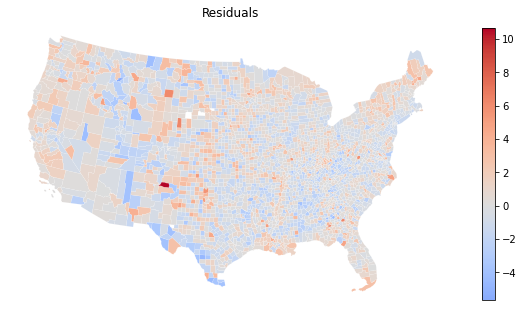

In [114]:
# merge and plot global OLS residuals
r = gdf_us[predictors].dropna()
r = gdf_us.loc[r.index]
r['residuals'] = residuals

fig, ax = plt.subplots(figsize=(10, 10))
r.plot(ax=ax,
       column='residuals',
       cmap=get_cmap(r['residuals']),
       edgecolor='white',
       linewidth=0.1,
       legend=True,
       legend_kwds={'shrink': 0.5})

plt.title(label='Residuals')
ax.set_axis_off()

In [122]:
# morans I on residuals
w_queen = ps.lib.weights.Queen.from_dataframe(r[['residuals', 'geometry']])
w_queen.set_transform('R')

/Users/marley/opt/miniconda3/envs/ppd599/lib/python3.9/site-packages/pysal/lib/weights/_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary)
/Users/marley/opt/miniconda3/envs/ppd599/lib/python3.9/site-packages/pysal/lib/weights/_contW_lists.py:26: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy))


In [134]:
# pick a variable to investigate (and drop null rows)
y = r['residuals']
r_lag = ps.lib.weights.lag_spatial(w_queen, r['residuals'])

col = 'residuals'
col_lag = 'residuals_lag'
data_lag = pd.DataFrame(data={col:y, col_lag:r_lag}).astype(float)
data_lag.head()

,residuals,residuals_lag
GEOID,,
31039,-2.003939,0.281515
31109,-0.492186,-0.204109
31129,-2.025954,-0.594947
31101,1.133962,-1.191269
31137,3.054452,1.553937


In [133]:
# calculate the statistic
mi = ps.explore.esda.Moran(data_lag[col], w_queen)
mi.I

0.15621177532988115

## 5. Geographically weighted regression

The problem with global regression models is that they are essentially spatial averages, obfuscating all the local variation in the process you're exploring. GWR allows us to investigate how model parameters and performance vary across the study area. It calibrates a regression model on each observation's local neighborhood then combines these into a global model for the study area. A user-defined *bandwidth* determines how these local models are calibrated: GWR estimates a model for each observation, using all the other observations weighted by their inverse-distance to that observation. The weighting is determined by fitting a *spatial kernel* to the data parameterized by the bandwidth distance.

Accordingly, the combination of bandwidth and kernel affects the smoothing (i.e., over-/under-fitting) of your model. Common kernels include the gaussian and bisquare. Bandwidth can be fixed or adaptive. If fixed, then the same distance is used for weighting across every observation's local neighborhood. However, this can introduce problems if your observations vary in density. Consider tracts: a tract in downtown LA may have 100 other tracts within 20km of it, but a tract in the Antelope Valley may have only 2 or 3 (too few for precise estimation). An adaptive bandwidth instead uses a fixed number of nearest neighbors to adjust the bandwidth distance accordingly: tracts in dense areas get a narrower bandwidth distance and tracts in sparse areas get a wider one. For more on GWR, [this book](https://www.wiley.com/en-us/Geographically+Weighted+Regression%3A+The+Analysis+of+Spatially+Varying+Relationships+-p-9780470855256) offers a good gentle introduction.

We need to specify fixed vs adaptive bandwidth ([adaptive](https://en.wikipedia.org/wiki/Variable_kernel_density_estimation)), spatial kernel ([gaussian](https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use)), optimization technique ([golden section](https://en.wikipedia.org/wiki/Golden-section_search)), and a criterion to minimize ([AICc](https://en.wikipedia.org/wiki/Akaike_information_criterion#AICc)).

In [ ]:
fixed_kernel = False
spatial_kernel = 'gaussian'
search = 'golden_section'
criterion = 'AICc'

In [ ]:
%%time
# select an adaptive (NN) bandwidth for our GWR model, given the data
centroids = gdf_us.loc[X.index].centroid
coords = list(zip(centroids.x, centroids.y))
sel = ps.model.mgwr.sel_bw.Sel_BW(coords=coords,
                                  y=Y.values,
                                  X_loc=X.values,
                                  kernel=spatial_kernel,
                                  fixed=fixed_kernel)
nn = sel.search(search_method=search, criterion=criterion)

In [ ]:
# what is the selected adaptive bandwidth value?
# ie, number of NNs to use to determine locally-varying bandwidth distances
nn

In [ ]:
%%time
# estimate the GWR model parameters
# pass fixed=False to treat bw as number of NNs (adaptive kernel)
model = ps.model.mgwr.gwr.GWR(coords=coords,
                              y=Y.values,
                              X=X.values,
                              bw=nn,
                              kernel=spatial_kernel,
                              fixed=fixed_kernel)
gwr = model.fit()

In [ ]:
# inspect the results
gwr.summary()

Compare the summary statistics across the local models (at bottom of output) to the global model (above).

In [ ]:
# a constant was added, so we'll add it to our predictors
cols = ['constant'] + predictors
cols

In [ ]:
# turn GWR local parameter estimates into a GeoDataFrame with tract geometries
params = pd.DataFrame(gwr.params, columns=cols, index=X.index)
params = gdf_us[['geometry']].merge(params, left_index=True, right_index=True, how='right')
params.head()

A common way to report GWR results is to visualize their spatial distribution.

First, we'll create a helper function to generate (properly centered and truncated) colormaps for our subsequent visualizations.

In [113]:
# helper function to generate colormaps for GWR plots
def get_cmap(values, cmap_name='coolwarm', n=256):
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap as lsc
    name = f'{cmap_name}_new'
    cmap = plt.cm.get_cmap(cmap_name)
    vmin = values.min()
    vmax = values.max()

    if vmax < 0:
        # if all values are negative, use the negative half of the colormap
        return lsc.from_list(name, cmap(np.linspace(0, 0.5, n)))
    elif vmin > 0:
        # if all values are positive use the positive half of the colormap
        return lsc.from_list(name, cmap(np.linspace(0.5, 1, n)))
    else:
        # otherwise there are positive and negative values so use zero as midpoint
        # and truncate the colormap such that if the original spans ± the greatest
        # absolute value, we only use colors from it spanning vmin to vmax
        abs_max = max(values.abs())
        start = (vmin + abs_max) / (abs_max * 2)
        stop = (vmax + abs_max) / (abs_max * 2)
        return lsc.from_list(name, cmap(np.linspace(start, stop, n)))

In [ ]:
len(predictors)

In [ ]:
# plot the spatial distribution of local parameter estimates
# set nrows, ncols to match your number of predictors!
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 10))
for col, ax in zip(predictors, axes.flat):
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'Local {col} coefficients')
    gdf = params.dropna(subset=[col], axis='rows')
    ax = gdf.plot(ax=ax,
                  column=col,
                  cmap=get_cmap(gdf[col]),
                  legend=True,
                  legend_kwds={'shrink': 0.6})
fig.tight_layout()

Above are our locally-varying parameter estimates. But they're not all statistically significantly different from zero. Where are they (in-)significant?

In [ ]:
# turn GWR local t-values into a GeoDataFrame with tract geometries
# set t-values below significance threshold to zero then clip to ± 4
# p<.05 corresponds to |t|>1.96, and |t|>4 corresponds to p<.0001
tvals = pd.DataFrame(gwr.filter_tvals(alpha=0.05), columns=cols, index=X.index).clip(-4, 4)
tvals = gdf_us[['geometry']].merge(tvals, left_index=True, right_index=True, how='right')

# plot the spatial distribution of local t-values
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 10))
for col, ax in zip(predictors, axes.flat):
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'Local {col} $t$ values')
    gdf = tvals.dropna(subset=[col], axis='rows')
    ax = gdf.plot(ax=ax,
                  column=col,
                  cmap=get_cmap(gdf[col]),
                  legend=True,
                  legend_kwds={'shrink': 0.6})
fig.tight_layout()

How well does our model perform across the study area?

In [ ]:
# turn GWR local R-squared values into a GeoDataFrame with tract geometries
col = 'Local $R^2$ values'
r_squared = pd.DataFrame(gwr.localR2, index=X.index, columns=[col])
r_squared = gdf_us[['geometry']].merge(r_squared, left_index=True, right_index=True, how='right')

# plot the spatial distribution of local R-squared values
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title(col)
gdf = r_squared.dropna(subset=[col], axis='rows')
ax = gdf.plot(ax=ax,
              column=col,
              cmap='Reds',
              legend=True,
              legend_kwds={'shrink': 0.6})
fig.tight_layout()

In [ ]:
# now it's your turn
# try increasing or decreasing the nearest neighbors bandwidth value above
# how does that change the model's results and visualizations?


## 6. Spatial diagnostics

So far we've seen different spatial heterogeneity models. Now we'll explore spatial dependence (modeling interdependencies between observations over space), starting by using queen-contiguity spatial weights to model spatial relationships between observations and OLS to check diagnostics.

In [ ]:
# compute spatial weights for only those tracts that appear in design matrix
W = ps.lib.weights.Queen.from_dataframe(gdf_us.loc[X.index])
W.transform = 'r'

In [ ]:
# compute OLS spatial diagnostics to check the nature of spatial dependence
ols = ps.model.spreg.OLS(y=Y.values,
                         x=X.values,
                         w=W,
                         spat_diag=True,
                         moran=True)

In [ ]:
# calculate moran's I (for the response) and its significance
mi = ps.explore.esda.Moran(y=Y, w=W, two_tailed=True)
print(mi.I)
print(mi.p_sim)

In [ ]:
# moran's I (for the residuals): moran's i, standardized i, p-value
ols.moran_res

Interpreting the results: a significant Moran's *I* suggests spatial autocorrelation, but doesn't tell us which alternative specification should be used. Lagrange Multiplier (LM) diagnostics can help with that. If one LM test is significant and the other isn't, then that tells us which model specification (spatial lag vs spatial error) to use.

In [ ]:
# lagrange multiplier test for spatial lag model: stat, p
ols.lm_lag

In [ ]:
# lagrange multiplier test for spatial error model: stat, p
ols.lm_error

Interpreting the results: if (and only if) both the LM tests produce significant statistics, try the robust versions (the nonrobust LM tests are sensitive to each other).

In [ ]:
# robust lagrange multiplier test for spatial lag model: stat, p
ols.rlm_lag

In [ ]:
# robust lagrange multiplier test for spatial error model: stat, p
ols.rlm_error

So... which model specification to choose? Workflow:

  1. If neither LM test is significant: use regular OLS.
  2. If only one LM test is significant: use that model spec.
  3. If both LM tests are significant: run robust versions.
  4. If only one robust LM test is significant: use that model spec.
  5. If both robust LM tests are significant (this can often happen with large sample sizes):
     1. first consider if the initial model specification is actually a good fit
     2. if so, use the spatial specification corresponding to the larger robust-LM statistic
     3. or consider a combo model

A hint for our working example here: our model is *not* well-specified!

## 7. Spatial lag model

When the diagnostics indicate the presence of a spatial diffusion process. Uses the spatially-lagged endogenous variable as a predictor. Because of endogeneity, cannot use OLS to estimate.

Model specification:

$y = \rho W y + \beta X + u$

where $y$ is a $n \times 1$ vector of observations (response), $W$ is a $n \times n$ spatial weights matrix (thus $Wy$ is the spatially-lagged response), $\rho$ is the spatial autoregressive parameter to be estimated, $X$ is a $n \times k$ matrix of observations (exogenous predictors), $\beta$ is a $k \times 1$ vector of parameters (coefficients) to be estimated, and $u$ is a $n \times 1$ vector of errors.

In [ ]:
# maximum-likelihood estimation with full matrix expression
mll = ps.model.spreg.ML_Lag(y=Y.values,
                            x=X.values,
                            w=W,
                            method='full',
                            name_w='queen',
                            name_x=X.columns.tolist(),
                            name_y=response,
                            name_ds='tracts')
print(mll.summary)

In [ ]:
# the spatial autoregressive parameter estimate, rho
mll.rho

Remember, from my assigned [JAPA article](https://osf.io/t9um6), that the interpretation of spatial-lag models is tricky:

> Due to spatial spillover, each coefficient alone does not represent the marginal effect on the response of a unit increase in the predictor. Instead, it represents the direct effect: what happens locally if you make a unit change in the predictor only in one tract. But also present are indirect effects: local spillovers in each tract from a unit predictor change in other tracts.

Refer to the article for details on how to calculate and interpret total effects.

## 8. Spatial error model

When the diagnostics indicate the presence of spatial error dependence (spatial effects in error term).

Model specification:

$y = \beta X + u$

where $X$ is a $n \times k$ matrix of observations (exogenous predictors), $\beta$ is a $k \times 1$ vector of parameters (coefficients) to be estimated, and $u$ is a $n \times 1$ vector of spatially autocorrelated errors. The errors $u$ follow a spatial autoregressive specification:

$u = \lambda Wu + \epsilon$

where $\lambda$ is a spatial autoregressive parameter to be estimated and $\epsilon$ is the vector of uncorrelated errors.

In [ ]:
# maximum-likelihood estimation with full matrix expression
mle = ps.model.spreg.ML_Error(y=Y.values,
                              x=X.values,
                              w=W,
                              method='full',
                              name_w='queen',
                              name_x=X.columns.tolist(),
                              name_y=response,
                              name_ds='tracts')
print(mle.summary)

In [ ]:
# the spatial autoregressive parameter estimate, lambda
mle.lam

In [ ]:
# now it's your turn
# re-calculate the spatial weights matrix using distance bands and linear decay
# how does that change the diagnostics, lag model, and error model results?


## 9. Spatial lag+error combo model

Estimated with GMM (generalized method of moments). Essentially a spatial error model with endogenous explanatory variables.

Model specification:

$y = \rho W y + \beta X + u$

where $y$ is a $n \times 1$ vector of observations (response), $W$ is a $n \times n$ spatial weights matrix (thus $Wy$ is the spatially-lagged response), $\rho$ is the spatial autoregressive parameter to be estimated, $X$ is a $n \times k$ matrix of observations (exogenous predictors), $\beta$ is a $k \times 1$ vector of parameters (coefficients) to be estimated, and $u$ is a $n \times 1$ vector of spatially autocorrelated errors.

The errors $u$ follow a spatial autoregressive specification:

$u = \lambda Wu + \epsilon$

where $\lambda$ is a spatial autoregressive parameter to be estimated and $\epsilon$ is the vector of uncorrelated errors.

In [ ]:
gmc = ps.model.spreg.GM_Combo_Het(y=Y.values,
                                  x=X.values,
                                  w=W,
                                  name_w='queen',
                                  name_ds='tracts',
                                  name_x=X.columns.tolist(),
                                  name_y=response)
print(gmc.summary)

## Wrap up

This has been a tour of different spatially-explicit modeling methods. Your results will only be as good as your initial model's specification! Are the OLS assumptions met? Did we choose theoretically sound predictors that are relatively uncorrelated with each other? Are our variables properly transformed for the best linear fit? In our working example today: no!

As a **self-paced exercise**, try including better predictors in the model. Transform them for a better linear fit with the response. Then see how this affects our spatial model results and interpretations.